In [1338]:
using Distributions, DistributionsAD, Plots, StatsPlots, LinearAlgebra, KernelFunctions, BlockDiagonals, MLDatasets

In [1339]:
xtrain, ytrain = MLDatasets.MNIST.traindata(Float32)
xtest, ytest = MLDatasets.MNIST.testdata(Float32)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [7, 2, 1, 0, 4, 1, 4, 9, 5, 9  …  7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

In [1142]:
import Base.+, Base.-, Base.*
using Flux


struct Gaussian
    μ
    Σ
end
Flux.@functor Gaussian


+(x::Gaussian, y::Gaussian) = Gaussian(x.μ .+ y.μ, x.Σ .+ y.Σ)
+(x::Gaussian, y::Vector) = Gaussian(x.μ .+ y, x.Σ)
+(x::Vector, y::Gaussian) = Gaussian(x .+ y.μ, y.Σ)

-(x::Gaussian, y::Gaussian) = Gaussian(x.μ .- y.μ, x.Σ .+ y.Σ)
-(x::Gaussian, y::Vector) = Gaussian(x.μ .- y, x.Σ)
-(x::Vector, y::Gaussian) = Gaussian(x .- y.μ, y.Σ)

*(x::Matrix, y::Gaussian) = Gaussian(x*y.μ, (x)*y.Σ*transpose(x))
        
*(x::Gaussian, y::Real) = Gaussian(y.*x.μ, y^2 .*x.Σ)
*(x::Real, y::Gaussian) = Gaussian(x.*y.μ, x^2 .*y.Σ)

Gaussian(m::Gaussian, S) = Gaussian(m.μ, S.+m.Σ)
Distributions.MvNormal(m::Gaussian) = Distributions.MvNormal(m.μ, Matrix(Hermitian(m.Σ.+Diagonal(ones(length(m.μ)).*1e-6))))

In [1143]:
struct DerivativeGP
    
    basekern
    covkern
    condkern
    
    varkern

end
Flux.@functor DerivativeGP



function (m::DerivativeGP)(x)
    
    g = Gaussian(zeros(size(x,2)),kernelmatrix(m.varkern,x))
    
    basekern = kernelmatrix(m.basekern, x)
    covkern = kernelmatrix(m.covkern, x)
    condkern = kernelmatrix(m.condkern, x)
    condkerni = inv(condkern .+ Diagonal(ones(size(x,2)).*1e-4))
            
    mm = covkern*condkerni*g
    cc = basekern.-covkern*condkerni*covkern
    
    return Gaussian(mm, cc)
    
    
end



function posterior(m::DerivativeGP,Xs ,x ,y)
    
    _,N = size(x)
    xl = hcat(x,Xs)
    
    mr = m(xl)
    
    mx = mr.μ[1:N]
    my = mr.μ[N+1:end]
    
    kxx = mr.Σ[1:N,1:N]
    kyy = mr.Σ[N+1:end,N+1:end]
    kxy = mr.Σ[1:N,N+1:end]
    
    kxxi = inv(kxx .+ Diagonal(ones(N).*1e-6))
    
    
    
    means = my .+ (transpose(kxy)*kxxi)*(y[:].-mx)
    covs = kyy .- transpose(kxy)*kxxi*kxy
    
    return Gaussian(means, covs)
end

posterior (generic function with 1 method)

In [1144]:
Xline = Matrix(transpose(collect(-3:0.25:3)[:,:]))

X = rand(1,50) .* 6 .- 3
y =  X .+ 1 .*randn(1,50)

1×50 Matrix{Float64}:
 0.690783  0.49675  -0.991584  -0.535749  …  -0.628565  2.26557  0.691839

In [1145]:
test = DerivativeGP(SqExponentialKernel(),SqExponentialKernel(),
                    SqExponentialKernel(),PolynomialKernel())


DerivativeGP(Squared Exponential Kernel, Squared Exponential Kernel, Squared Exponential Kernel, Polynomial Kernel (c = 0.0, degree = 2))

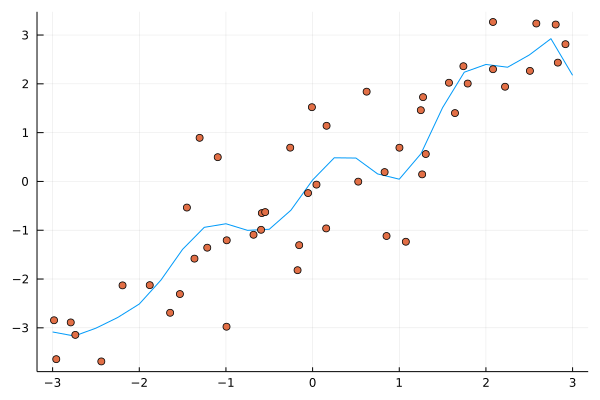

In [1146]:
plot(Xline[:],posterior(test, Xline,X,y).μ,legend=:none)
scatter!(X[:],y[:])

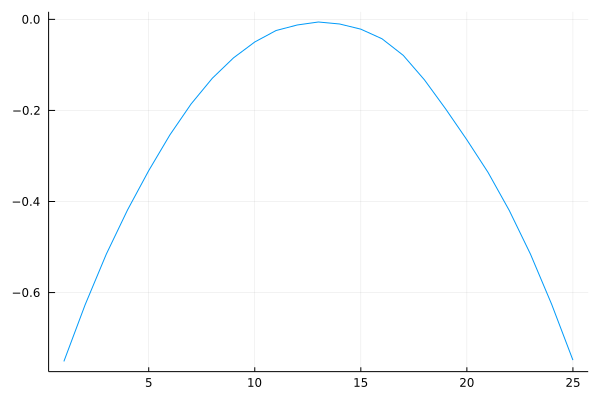

In [1147]:


plot(rand(MvNormal(test(Xline))),legend=:none)

In [1148]:
M=3

IZ = rand(1,M) .* 12 .- 6
mZ = (-1 .* IZ)
SZ = kernelmatrix(SqExponentialKernel(),IZ).+Diagonal(ones(M).*1e-5)

Xline = Matrix(transpose(collect(-10:0.1:10)[:,:]))
R = size(Xline,2)

Z = 3

IU = rand(1,Z) .* 4 .- 2
mU = randn(1,Z)
SU = kernelmatrix(SqExponentialKernel(),IU).+Diagonal(ones(Z).*1e-5)


xz = hcat(Xline, IU)

1×204 Matrix{Float64}:
 -10.0  -9.9  -9.8  -9.7  -9.6  -9.5  …  10.0  1.44278  1.30684  -0.865957

In [1149]:
var1 = Gaussian(mZ[:], SZ)
var2 = Gaussian(mU[:], SU)

Gaussian([-0.8581382597218195, -0.6169550023747609, 1.635644543931368], [1.00001 0.9908036234788009 0.06959074033525903; 0.9908036234788009 1.00001 0.09437027664878862; 0.06959074033525903 0.09437027664878862 1.00001])

In [1150]:
Kxz = kern(xz,IZ)
Kzz = kern(IZ)
Kzzi = inv(Kzz .+ Diagonal(ones(M).*1e-6))
Kxx = kern(xz,xz)
Kxlxl = kern(Xline,Xline)

Kxu = kern(Xline,IU)
Kzu = kern(IZ,IU)

Kuu = kern(IU)
Kuui = inv(Kuu .+ Diagonal(ones(Z).*1e-6))
    

Kuuzz = Kuu .-transpose(Kzu)*Kzzi*Kzu
Kuuzzi = inv(Kuuzz .+ Diagonal(ones(Z).*1e-6))
    
upper = BlockDiagonal([Diagonal(ones(R)), Kxu*Kuui])
downer = hcat(Diagonal(ones(R)), Diagonal(ones(R)))

aug = Matrix(downer*upper)


meanfun = Gaussian(Kxz*Kzzi*var1, Kxx.-Kxz*Kzzi*transpose(Kxz))

mf = aug*meanfun + Kxu*Kuui*var2
sf = Kxlxl .- Kxu*Kuui*transpose(Kxu)

out = Gaussian(mf, sf)

Gaussian([1.5919842734877423e-18, 3.95262615215767e-18, 9.716294414031883e-18, 2.3647422744486676e-17, 5.698170728933652e-17, 1.359426926052987e-16, 3.2110371296374416e-16, 7.50938073130619e-16, 1.7387316151711634e-15, 3.985941387293797e-15  …  -3.5939599946053512e-9, -1.88780994472933e-9, -9.817584056469514e-10, -5.0548914766867e-10, -2.576792617209519e-10, -1.3004903798324632e-10, -6.498221773872811e-11, -3.214706467382741e-11, -1.574516670103568e-11, -7.635053955594006e-12], [2.0 1.9900249583853737 … 6.231732815130873e-34 2.6859028704241434e-34; 1.9900249583853737 2.0 … 1.5457516356094877e-33 6.6622846083663585e-34; … ; 6.231732815126932e-34 1.545751635608484e-33 … 2.0 1.9900249583853737; 2.6859028704240467e-34 6.662284608366069e-34 … 1.9900249583853737 2.0])

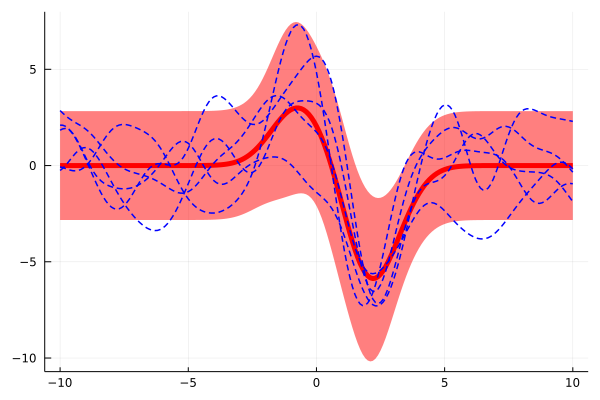

In [1151]:
plot(Xline[:],out.μ, ribbon = 2 .* sqrt.(diag(out.Σ)),legend=:none, lw=5,color=:red)
plot!(Xline[:],rand(MvNormal(out)),color=:blue, lw=1.5,s=:dash)
plot!(Xline[:],rand(MvNormal(out)),color=:blue, lw=1.5,s=:dash)
plot!(Xline[:],rand(MvNormal(out)),color=:blue, lw=1.5,s=:dash)
plot!(Xline[:],rand(MvNormal(out)),color=:blue, lw=1.5,s=:dash)
plot!(Xline[:],rand(MvNormal(out)),color=:blue, lw=1.5,s=:dash)


In [1152]:
mutable struct SEKernel <: KernelFunctions.Kernel
     
    se_variance
    se_lengthscale

end

Flux.@functor SEKernel


SEKernel() = SEKernel(zeros(1,1), zeros(1,1))


function KernelFunctions.kernelmatrix(m::SEKernel,x::Matrix,y::Matrix)

    diffed = sum((Flux.unsqueeze(x,3) .- Flux.unsqueeze(y,2)).^2,dims=1)[1,:,:]
    
    return exp(m.se_variance[1,1]) .* exp.(- 0.5 *exp(m.se_lengthscale[1,1]) .* diffed)

end

KernelFunctions.kernelmatrix(m::SEKernel,x::Matrix) = KernelFunctions.kernelmatrix(m,x,x)


function crossderivativekernel(m::SEKernel,x::Matrix,y::Matrix)

    diffed = Flux.unsqueeze(x,3) .- Flux.unsqueeze(y,2)
    kern = Flux.unsqueeze(kernelmatrix(m,x,y),1)
    
    result =  exp(m.se_lengthscale[1,1]) .* diffed .* kern
    
    return hcat(Flux.unstack(result,1)...)
    
end


crossderivativekernel(m::SEKernel,x::Matrix) = crossderivativekernel(m,x,x)


function doaug(k,n,m)
    
    result = zeros(k,k,n,m,k*n,k*m)
    
    for i in 1:k
        for j in 1:k
            for s in 1:n
                for t in 1:m
                    result[i,j,s,t,((i-1)*n+s),((j-1)*m+t)] = 1.
                end
            end
        end
    end
    
    return result
end
Zygote.@nograd doaug


function derivativekernel(m::SEKernel, x::Matrix, y::Matrix)
    
    k,n = size(x)
    mm = size(y,2)
    
    diffed = Flux.unsqueeze(x,3) .- Flux.unsqueeze(y,2)
    diffed = Flux.unsqueeze(diffed,1) .* Flux.unsqueeze(diffed,2)
    
    
    kern = Flux.unsqueeze(Flux.unsqueeze(kernelmatrix(m,x,y),1),1)
    
    result =  -exp(m.se_lengthscale[1,1]) .* kern .+ exp(m.se_lengthscale[1,1]).^2 .* diffed .* kern
    
    
    
    aug = doaug(k,n,mm)
    
    return -sum(aug.*result,dims=(1,2,3,4))[1,1,1,1,:,:]
end


derivativekernel(m::SEKernel,x::Matrix) = derivativekernel(m,x,x)

derivativekernel (generic function with 2 methods)

In [1154]:
using Zygote, LinearAlgebra

In [1155]:
test = SEKernel(zeros(1,1), - 2 .*ones(1,1))

SEKernel([0.0], [-2.0])

In [1302]:
X = rand(1,100).*10 .- 5
Xline = Matrix(transpose(collect(-3:0.25:3)[:,:]))

    
sig = 0.5
y = sin.(2.5 .*X) .+ randn(1,100).*sig

1×100 Matrix{Float64}:
 -1.84846  -0.940616  0.916955  0.134883  …  0.811953  -0.0498494  -0.287368

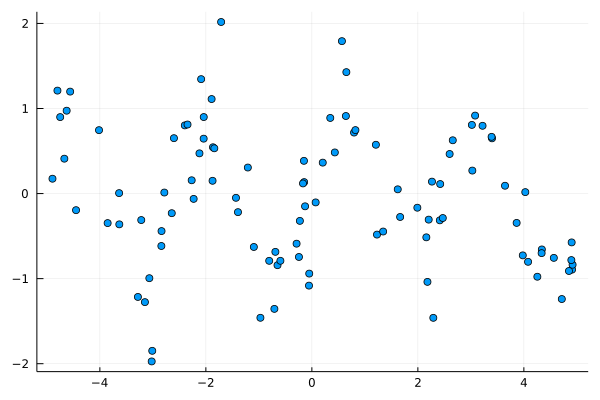

In [1303]:
scatter(X[:],y[:],legend=:none)

In [1158]:
dk

100×121 Matrix{Float64}:
 3.26528e-8   5.92625e-8   1.06458e-7   …  -4.34154e-7   -2.47916e-7
 1.0943e-8    2.02291e-8   3.70136e-8      -1.15426e-6   -6.71403e-7
 2.53534e-7   4.43812e-7   7.68929e-7      -5.78899e-8   -3.18836e-8
 0.000207756  0.00031589   0.000475278     -7.46461e-12  -3.57945e-12
 7.39043e-13  1.57451e-12  3.32051e-12     -0.000736285  -0.000495087
 6.88103e-12  1.42205e-11  2.90907e-11  …  -0.000217802  -0.000141914
 3.28199e-5   5.21114e-5   8.18833e-5      -1.40211e-10  -7.01296e-11
 9.58516e-21  2.5246e-20   6.58257e-20     -0.245534     -0.208394
 4.14809e-14  9.17518e-14  2.00896e-13     -0.0029071    -0.00203293
 8.85809e-6   1.44685e-5   2.3388e-5       -8.7585e-10   -4.50405e-10
 6.94479e-20  1.79154e-19  4.57513e-19  …  -0.172955     -0.143204
 2.32717e-24  6.65856e-24  1.88604e-23     -0.574021     -0.544959
 4.36475e-9   8.19071e-9   1.52137e-8      -2.50688e-6   -1.48043e-6
 ⋮                                      ⋱                 ⋮
 3.3086e-6    5.514

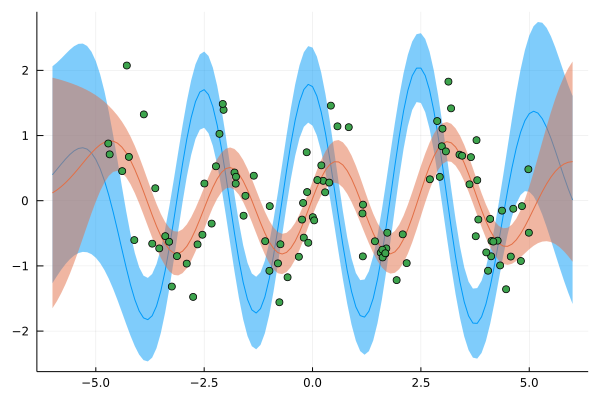

In [1159]:
test = SEKernel(zeros(1,1), zeros(1,1))

k = kernelmatrix(test,X)
dk = crossderivativekernel(test,X,Xline)
ddk = derivativekernel(test, Xline)

L = cholesky(k.+Diagonal(ones(size(k,2)).*sig^2)).L
v = L\dk


means = transpose(transpose(L)\(L\transpose(y)))*dk
covs =  ddk .- transpose(v)*v


dkk = kernelmatrix(test, X, Xline)
ddkk = kernelmatrix(test, Xline)

L = cholesky(k.+Diagonal(ones(size(k,2)).*sig^2)).L
v = L\dkk


means2 = transpose(transpose(L)\(L\transpose(y)))*dkk
covs2 =  ddkk .- transpose(v)*v


plot(Xline[:],means[:], ribbon = 2 .*sqrt.(diag(covs)),legend=:none)
plot!(Xline[:],means2[:], ribbon = 2 .*sqrt.(diag(covs2)),legend=:none)
#plot!(Xline[:], 2 .*cos.(2 .*Xline[:]))
scatter!(X[:],y[:])

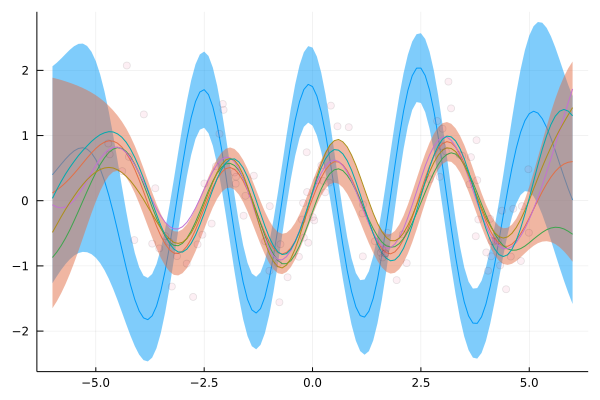

In [1160]:
ddd = Distributions.MvNormal(means2[:],covs2.+Diagonal(ones(size(Xline,2)).*1e-6))
        
plot(Xline[:],means[:], ribbon = 2 .*sqrt.(max.(0,diag(covs))),legend=:none)
plot!(Xline[:],means2[:], ribbon = 2 .*sqrt.(max.(0,diag(covs2))),legend=:none)
plot!(Xline[:],rand(ddd),legend=:none)
plot!(Xline[:],rand(ddd),legend=:none)
plot!(Xline[:],rand(ddd),legend=:none)
plot!(Xline[:],rand(ddd),legend=:none)

#plot!(Xline[:], 2 .*cos.(2 .*Xline[:]))
scatter!(X[:],y[:],alpha=0.1)

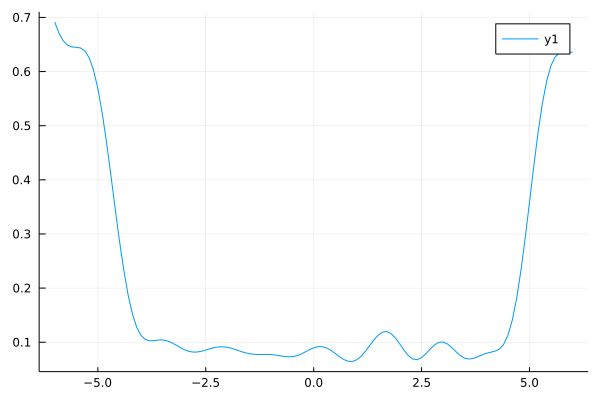

In [1161]:
plot(Xline[:],diag(covs))

In [1238]:
struct SVGPG
     
    L
    a
    I
    
    kern
    s
    
end
Flux.@functor SVGPG




SVGPG(kern, ndims=1, nind=5) = SVGPG(randn(nind,nind), randn(1,nind), rand(ndims,nind).*6 .-3, kern, zeros(1,1))


function (m::SVGPG)(x)
    
    S = m.L*transpose(m.L)
    
    Kmm = kernelmatrix(m.kern,m.I)
    Kmn = kernelmatrix(m.kern,m.I,x)
    Knn = kernelmatrix(m.kern,x)
    
    L = cholesky(Kmm.+Diagonal(ones(size(Kmm,2)).*exp(m.s[1,1]))).L
    v = L\Kmn


    means = transpose(transpose(L)\(L\transpose(m.a)))*Kmn
    covs =  Knn .- transpose(v)*v
    
    return Gaussian(means[:], covs)

end



struct ∂SVGPG
    
    SVGP
    
end
Flux.@functor ∂SVGPG


∂(m::SVGPG) = ∂SVGPG(m)

function (mm::∂SVGPG)(x)
    
    m = mm.SVGP
    
    S = m.L*transpose(m.L)
    
    Kmm = kernelmatrix(m.kern,m.I)
    Kmn = crossderivativekernel(m.kern,m.I,x)
    Knn = derivativekernel(m.kern,x)
    
    L = cholesky(Kmm.+Diagonal(ones(size(Kmm,2)).*exp(m.s[1,1]))).L
    v = L\Kmn


    means = transpose(transpose(L)\(L\transpose(m.a)))*Kmn
    covs =  Knn .- transpose(v)*v
    
    return Gaussian(means[:], covs)

end



In [1239]:
test = SVGPG(SEKernel())
    
dm = MvNormal(∂(test)(Xline))

FullNormal(
dim: 121
μ: [-0.0002373686014606629, -0.00033426353851130907, -0.0004657456181034285, -0.0006420932469126105, -0.0008758586069963185, -0.0011821034993955623, -0.0015785715034717948, -0.0020857647443455556, -0.0027268930105881313, -0.003527666415943122  …  0.042380031922713626, 0.03541582288862073, 0.02924897684964515, 0.02387590134943686, 0.01926623848599377, 0.015369832055047357, 0.012123239652944425, 0.009455487718212266, 0.0072928889488808055, 0.005562849354783797]
Σ: [0.9999949687982728 0.9850538671153483 … -6.409220455784518e-8 -4.903106863435374e-8; 0.9850538671153483 0.9999890564409929 … -9.015555556382042e-8 -6.896975790689559e-8; … ; -6.409220455784518e-8 -9.015555556382042e-8 … 0.9993979349716701 0.9846022822580761; -4.903106863435374e-8 -6.896975790689559e-8 … 0.9846022822580761 0.9996500156523369]
)


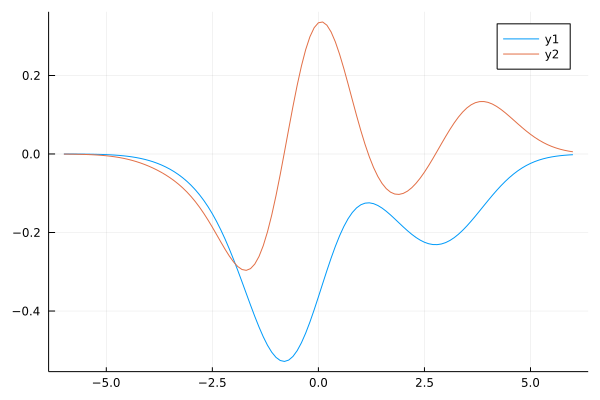

In [1240]:
plot(Xline[:],mean(Distributions.MvNormal(test(Xline))))
plot!(Xline[:], mean(dm))

In [1307]:
struct DGP
    
    SVGPS
    s
    
end
Flux.@functor DGP



DGP(svgps) = DGP(svgps, zeros(1,1))
    

function Base.rand(m::DGP,x)

    output = x
    
    for gp in m.SVGPS
        output = Base.rand(gp,output)
    end
    
    return output

end



struct ∂DGP
    
    DGP
    
end
Flux.@functor ∂DGP


∂(m::DGP) = ∂DGP(m)



function Base.rand(mm::∂DGP,x)
    
    m = mm.DGP
    
    n = size(x,2)
    k = length(m.SVGPS)
    
    gpout = zeros(k+1,n)
    gpout[1,:] = x[:]
    gpgout = zeros(k,n)
    
    
    
    for gp in 1:k
        gpout[gp+1,:] = Base.rand(m.SVGPS[gp],gpout[gp:gp,:])[:]
        gpgout[gp,:] = Base.rand(∂(m.SVGPS[gp]),gpout[gp+1:gp+1,:])[:]
    end
        
    return gpout, gpgout

end


In [1308]:
Base.rand(∂(test2),Xline)

([-3.0 -2.75 … 2.75 3.0; -0.43751114695675486 -0.11775905056089242 … -0.28236742821792205 -0.5632804076352891; 1.2150614025893773 1.2820114708004562 … 1.2713674360325733 1.1417212196717266], [-1.4100470619560965 -1.491565847511163 … -1.513001133697086 -1.2501834630065716; -0.1974824912051965 -0.20795738019653787 … -0.2075109845161906 -0.18048746214096195])

In [1304]:
test2 = DGP([SVGPG(SEKernel()) for _ in 1:2])

DGP(SVGPG[SVGPG([-0.9482912374344453 0.043795103315968226 … -1.2760328172157642 1.0245170963342294; -0.2272848707509745 0.5955114542564157 … -1.746387897757541 0.036175527752063154; … ; -0.44567831187107454 0.22831361867622757 … -0.5588984133228743 -0.3948974761208854; 0.5663595917585261 0.6457322864106086 … -0.3741053028226048 -0.7100827781231991], [1.4090169843027867 0.026961346550128124 … -1.8023366996133112 0.7840523416969933], [-2.9196138565358916 1.8980275160849889 … 2.836579096999788 1.78898035592945], SEKernel([0.0], [0.0]), [0.0]), SVGPG([0.1446649345791719 1.514452549994836 … -0.9381170544166523 0.7767206678950613; 0.2730076547451948 1.4642925616750473 … -0.692891208136913 0.5302353532735679; … ; 0.9111484695523598 -0.7831168285076565 … -0.013370757850249737 0.08349038891914833; -0.24574882756637564 1.6638629131843112 … -0.8154866093511014 -0.2846883207272709], [0.14397674716588488 1.842897914256754 … -1.0223180755782588 0.4225455568943809], [0.9694184347986914 -1.12020725123

In [1336]:
samped = []
sampedp = []

for i in 1:1000
    out, outp = Base.rand(∂(test2),Xline)
    push!(samped, out[end,:])
    push!(sampedp, prod(outp,dims=1)[:])
end

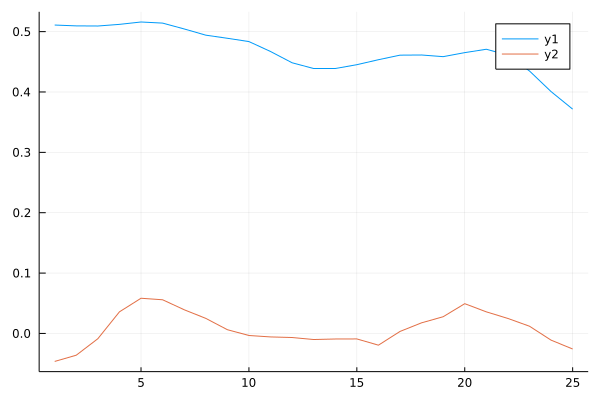

In [1337]:
ssamped = hcat(samped...)
means = mean(ssamped, dims=2)[:]
stds = std(ssamped, dims=2)[:]

ssampeds = hcat(sampedp...)
meanss = mean(ssampeds, dims=2)[:]
stdss = std(ssampeds, dims=2)[:]

plot(means)
plot!(meanss)

In [1253]:
function Base.rand(m::SVGPG, x)
    
    out = m(x)
    mu = out.μ[:,:]
    #sig = sqrt.(diag(out.Σ)[:,:])
    sig = cholesky(out.Σ.+Diagonal(ones(size(x,2)).*1e-6)).L
    
    return Matrix(transpose(sig*randn(size(x,2),1).+mu))
    
end


function Base.rand(m::∂SVGPG, x)
    
    out = m(x)
    mu = out.μ[:,:]
    sig = cholesky(out.Σ.+Diagonal(ones(size(x,2)).*1e-6)).L
    
    return Matrix(transpose(sig*randn(size(x,2),1).+mu))
    
end




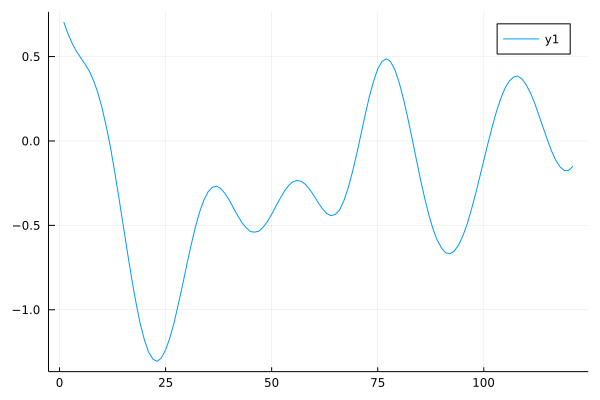

In [1254]:
plot(rand(test, Xline)[:])

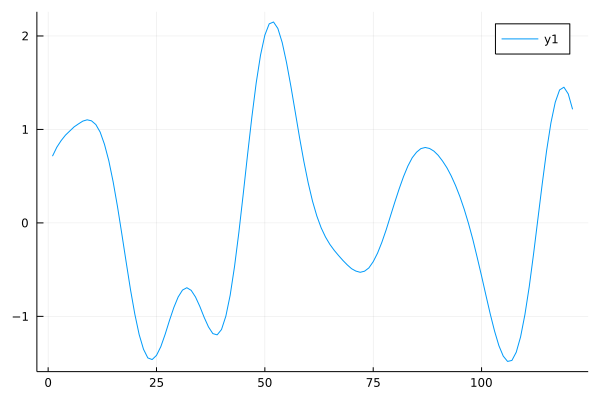

In [1298]:
plot(rand(∂(test), Xline)[:])